# NYU - ML4C FINAL PROJECT
## Brief
This notebook 
- imports the shapefile
- imports taxi_count results
- merges shapefiles with taxi_counts
- maps taxi_counts
- outputs a .csv of the results
- You can refer to https://github.com/mv1742/ml4cities

In [4]:
# ! pip install sklearn
#! pip install geopandas
#import all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
%pylab inline

# To ignore some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import requests
import shapely
import json
from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
# import geopy.distance
#from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
#pd.options.display.max_columns = None
DEVELOPING = False
#from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
#from evalChisq import evalChisqgeoid

from urllib.error import HTTPError
import urllib.request as request
try:
    from urllib import urlretrieve as urlretrieve
except ImportError:
    from urllib.request import urlretrieve as urlretrieve

Populating the interactive namespace from numpy and matplotlib


In [5]:
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas import GeoDataFrame
from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /home/mv1742/Capstone/udpny_2


In [7]:
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('TaxiData')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)

# Import Shape Files
#### Retrieved from latest Census 2016 results from NYC Planning Metro Region Explorer:
https://metroexplorer.planning.nyc.gov/about

and four missing census tracts from census.gov American Fact Finder: https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml


In [9]:
url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
NYCzip = getGeoDataFrameFromShpFileZipUrl(url)
# NYCzip=gpd.read_file('Censustracts/region.shp')

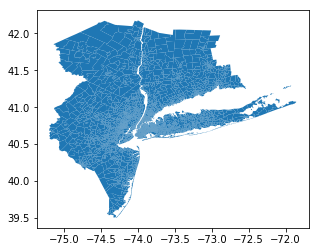

In [10]:
NYCzip.plot()

In [11]:
NYCzip.columns

Index(['aland_mi', 'objectid', 'statefp', 'countyfp', 'tractce', 'geoid',
       'name', 'namelsad', 'mtfcc', 'funcstat', 'aland', 'awater', 'intptlat',
       'intptlon', 'shape_leng', 'shape_area', 'atotal', 'atotal_mi',
       'cartodb_id', 'geoid_1', 'hou16', 'hou16moe', 'hou16cv', 'houv16',
       'houv16moe', 'houv16cv', 'houo16', 'houo16moe', 'houo16cv', 'hour16',
       'hour16moe', 'hour16cv', 'emtot15', 'empr15', 'emoff15', 'emins15',
       'emind15', 'emser15', 'emoth15', 'geometry'],
      dtype='object')

In [12]:
NYCzip

,aland_mi,objectid,statefp,countyfp,tractce,geoid,name,namelsad,mtfcc,funcstat,...,hour16moe,hour16cv,emtot15,empr15,emoff15,emins15,emind15,emser15,emoth15,geometry
0,10.14335,17,34,013,021601,34013021601,216.01,Census Tract 216.01,G5020,S,...,109.0,25.583551,22750.0,22492.0,7641.0,1229.0,10729.0,2162.0,731.0,"POLYGON ((-74.3228040001045 40.90883400018899,..."
1,3.16034,27,34,003,031100,34003031100,311,Census Tract 311,G5020,S,...,214.0,10.602379,8274.0,8172.0,3602.0,219.0,3181.0,1084.0,86.0,POLYGON ((-74.08304199968846 40.78623200040653...
2,1.84139,50,34,003,036200,34003036200,362,Census Tract 362,G5020,S,...,75.0,19.156599,8825.0,8224.0,1252.0,217.0,5718.0,975.0,62.0,POLYGON ((-74.03536299980257 40.82861799992076...
3,0.03451,95,34,017,003500,34017003500,35,Census Tract 35,G5020,S,...,67.0,6.133958,58.0,58.0,33.0,7.0,4.0,14.0,0.0,POLYGON ((-74.04668899959766 40.72066899957468...
4,0.11672,108,34,017,015500,34017015500,155,Census Tract 155,G5020,S,...,137.0,6.123726,676.0,620.0,82.0,106.0,84.0,321.0,27.0,POLYGON ((-74.01458600034361 40.79119299985706...
5,0.12662,130,34,013,013200,34013013200,132,Census Tract 132,G5020,S,...,127.0,11.804839,93.0,93.0,11.0,2.0,6.0,65.0,9.0,POLYGON ((-74.21338700040968 40.73388700028482...
6,3.58591,203,34,027,044501,34027044501,445.01,Census Tract 445.01,G5020,S,...,147.0,12.693424,3505.0,3185.0,683.0,48.0,195.0,2134.0,125.0,(POLYGON ((-74.56219999983014 40.9012120003335...
7,1.32701,209,34,023,004500,34023004500,45,Census Tract 45,G5020,S,...,144.0,4.937281,718.0,718.0,171.0,2.0,492.0,41.0,12.0,(POLYGON ((-74.25451090392684 40.5403372012258...
8,1.36273,225,34,003,007001,34003007001,70.01,Census Tract 70.01,G5020,S,...,81.0,16.468268,1115.0,1114.0,194.0,292.0,376.0,206.0,46.0,POLYGON ((-73.96304000019583 40.98273799985878...
9,0.31952,237,34,003,019102,34003019102,191.02,Census Tract 191.02,G5020,S,...,88.0,7.471430,1707.0,1549.0,706.0,478.0,212.0,118.0,35.0,"POLYGON ((-73.95468099962847 40.8616329998631,..."


In [13]:
NYCzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape

(5294, 2)

In [14]:
NYCzip.isnull().sum()

GEOID       0
geometry    0
dtype: int64

In [15]:
# NYCzipgdp.dropna(inplace=True)
NYCzip.shape

(5294, 2)

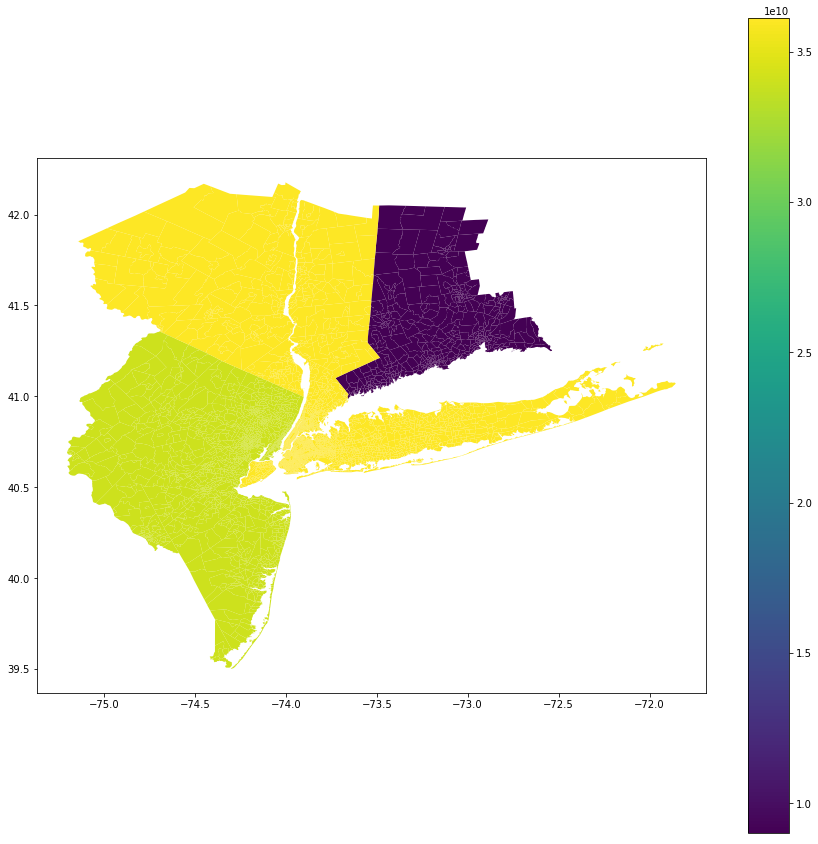

In [16]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzip.plot(column='GEOID',legend = True, ax=ax)

# Import Latest Typologies (Jan 2019)
#### Retrieved from latest results from Jan 19. Provided by Dr. Karen Chapple by email on April 12th 2019.

In [92]:
taxi_count=pd.read_csv('ALLbatches_SS20.csv')
taxi_countgpd = gpd.GeoDataFrame(taxi_count)
len(taxi_count.columns)

5

In [93]:
taxi_count.rename(columns={'geoid': "GEOID"},inplace=True)
taxi_count.tail()

,Unnamed: 0,census_tract,greenCabCount,images,yelloCabCount
1809,104,36085030301,0,20,0
1810,105,36085030302,0,20,0
1811,106,36085031901,1,20,0
1812,107,36085031902,2,20,0
1813,108,36085032300,1,20,0


In [94]:
cols_typ = ['census_tract','yelloCabCount','greenCabCount']
print(type(taxi_count.iloc[:,0][0]))
#Typologies.rename(columns={'\ufeffgeoid': "GEOID"},inplace=True)
#Typologiesgdp.geoid = Typologies.iloc[:,0]
taxi_count = taxi_count.loc[:,cols_typ]
taxi_count.head()

<class 'numpy.int64'>


,census_tract,yelloCabCount,greenCabCount
0,36047000100,1,3
1,36047000200,0,1
2,36047000301,0,0
3,36047000501,0,2
4,36047000502,0,0


In [95]:
taxi_count.shape

(1814, 3)

In [96]:
taxi_count.dropna(inplace=True)
taxi_count.census_tract = taxi_count.census_tract.astype(int)

## Clean Data

## Clean Typologies

In [97]:
#NYCzipgdp.isnull().sum()
taxi_count.isin([0]).sum()

census_tract        0
yelloCabCount    1251
greenCabCount     430
dtype: int64

In [98]:
taxi_count.isnull().sum()

census_tract     0
yelloCabCount    0
greenCabCount    0
dtype: int64

In [99]:
print(len(taxi_count.census_tract.unique()))
taxi_count.dropna(inplace=True)
taxi_count.shape

1814


(1814, 3)

In [100]:
taxi_count =taxi_count.drop_duplicates()
taxi_count.shape

(1814, 3)

In [101]:
# print(NYCzipgdp.shape)
taxi_count.rename(columns={'census_tract': "GEOID"},inplace=True)

In [102]:
taxi_count.tail()

,GEOID,yelloCabCount,greenCabCount
1809,36085030301,0,0
1810,36085030302,0,0
1811,36085031901,0,1
1812,36085031902,0,2
1813,36085032300,0,1


### MERGE

In [103]:
merged = NYCzip.merge(taxi_count,on='GEOID')
merged.tail()

,GEOID,geometry,yelloCabCount,greenCabCount
1809,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,1,9
1810,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,3,7
1811,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",3,7
1812,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,0,2
1813,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",0,0


In [104]:
print(type(merged),merged.shape)
mergedgpd = gpd.GeoDataFrame(merged)
mergedgpd.shape

<class 'geopandas.geodataframe.GeoDataFrame'> (1814, 4)


(1814, 4)

In [105]:
mergedgpd.isnull().sum()

GEOID            0
geometry         0
yelloCabCount    0
greenCabCount    0
dtype: int64

In [106]:
print(len(taxi_count.GEOID),len(mergedgpd.GEOID))
print(type(taxi_count.GEOID),type(mergedgpd.GEOID))

1814 1814
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [107]:
excluded = []
for i in taxi_count.GEOID:
    if i not in list(mergedgpd.GEOID):
        print('i',i)
        excluded.append(i)
excluded

[]

In [108]:
(NYCzip.GEOID == 36061022102).sum()

1

In [109]:
# mergedgpd.crs = from_epsg(4326)
# mergedgpd.crs

In [110]:
# mergedgpd.to_crs(epsg=2263, inplace = True)
# mergedgpd.crs

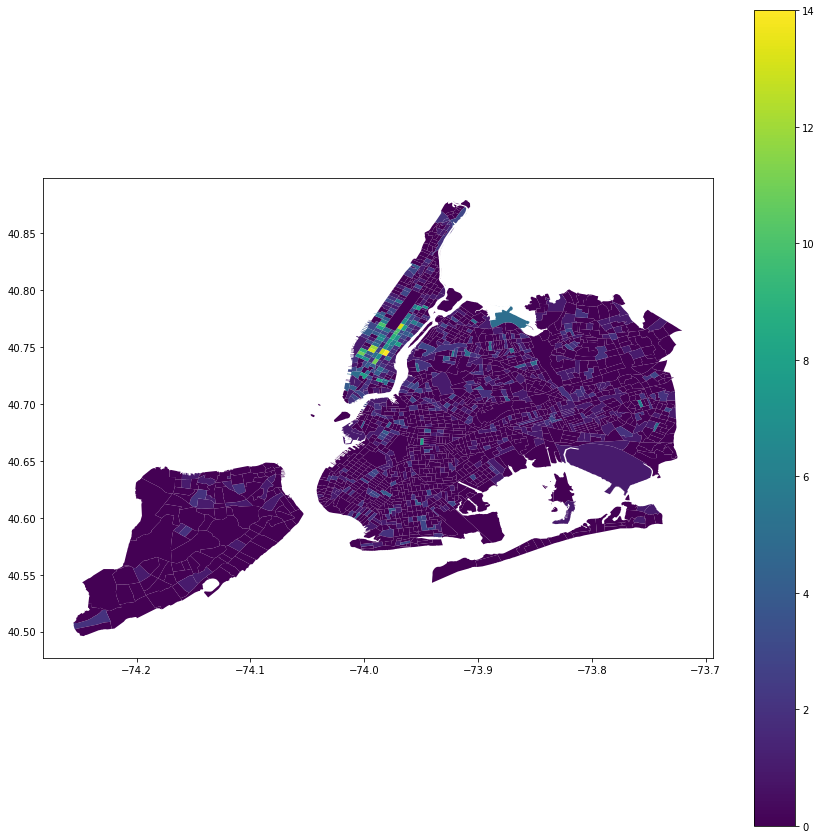

In [111]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='yelloCabCount',legend = True, ax=ax)

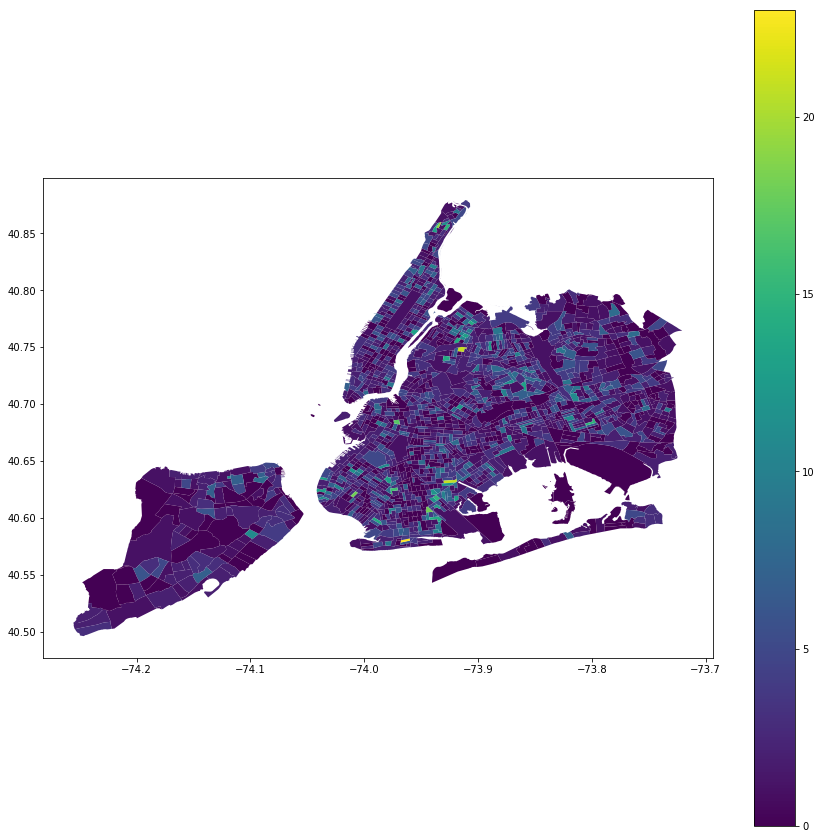

In [113]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='greenCabCount',legend = True, ax=ax)

In [114]:
# mergedgpd.to_csv('UDPNY_shapefilesTypology_final_1.19.19.csv')

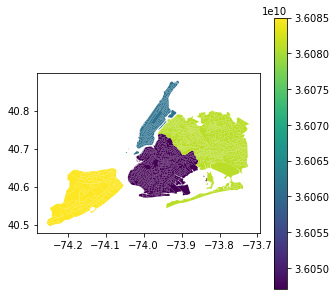

In [115]:
figure, ax = plt.subplots(figsize=(5, 5))
mergedgpd.plot(column='GEOID',legend = True, ax=ax)

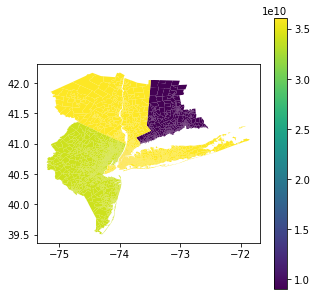

In [116]:
figure, ax = plt.subplots(figsize=(5, 5))
NYCzip.plot(column='GEOID',legend = True, ax=ax)